[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Entrenamiento de una YOLOv11 sobre un corpus propio

---

YOLO11 se basa en los avances introducidos en YOLOv9 y YOLOv10 a principios de este año, incorporando diseños arquitectónicos mejorados, técnicas de extracción de características optimizadas y métodos de entrenamiento perfeccionados.

YOLO11m logra una puntuación mAP media más alta en el conjunto de datos COCO utilizando un 22% menos de parámetros que YOLOv8m, lo que lo hace computacionalmente más ligero sin sacrificar rendimiento.

YOLOv11 está disponible en 5 tamaños diferentes, desde `2.6M` a `56.9M` de parámetros, siendo capaz de obtener desde `39.5` a `54.7` de mAP sobre el dataset COCO.

Revisamos la GPU a la que nos conectamos

In [ ]:
!nvidia-smi

Thu Nov 27 14:30:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Instalación de YOLO11 desde Ultralytics

In [ ]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.4/112.6 GB disk)


## Uso out-of-the-box

Vamos a usar el modelo más pequeño para hacer inferencia y que nos dé todas las detecciones de las clases que ya tiene pre-entrenadas (dataset COCO).

In [ ]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='/content/drive/MyDrive/plaza1.jpg' save=True

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 /content/drive/MyDrive/plaza1.jpg: 448x640 5 persons, 1 umbrella, 1 surfboard, 102.0ms
Speed: 6.1ms preprocess, 102.0ms inference, 6.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/runs/detect/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


El resultado queda en la carpeta /runs/detect/predict, que va agregando números al final cada vez que hacemos una nueva inferencia, ej: /predict1, /predict2, etc., de manera de no perder los resultados previos.

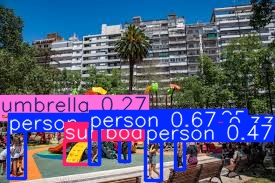

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/plaza1.jpg', width=600)

**Sobre una imagen de un fernet**

Queremos ver ahora cómo se comporta en la detección de un fernet (clase no presente en el dataset COCO!)

In [ ]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='/content/drive/MyDrive/fernet.jpg' save=True

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 /content/drive/MyDrive/fernet.jpg: 640x640 1 sports ball, 1 bottle, 10.5ms
Speed: 3.8ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict4
💡 Learn more at https://docs.ultralytics.com/modes/predict


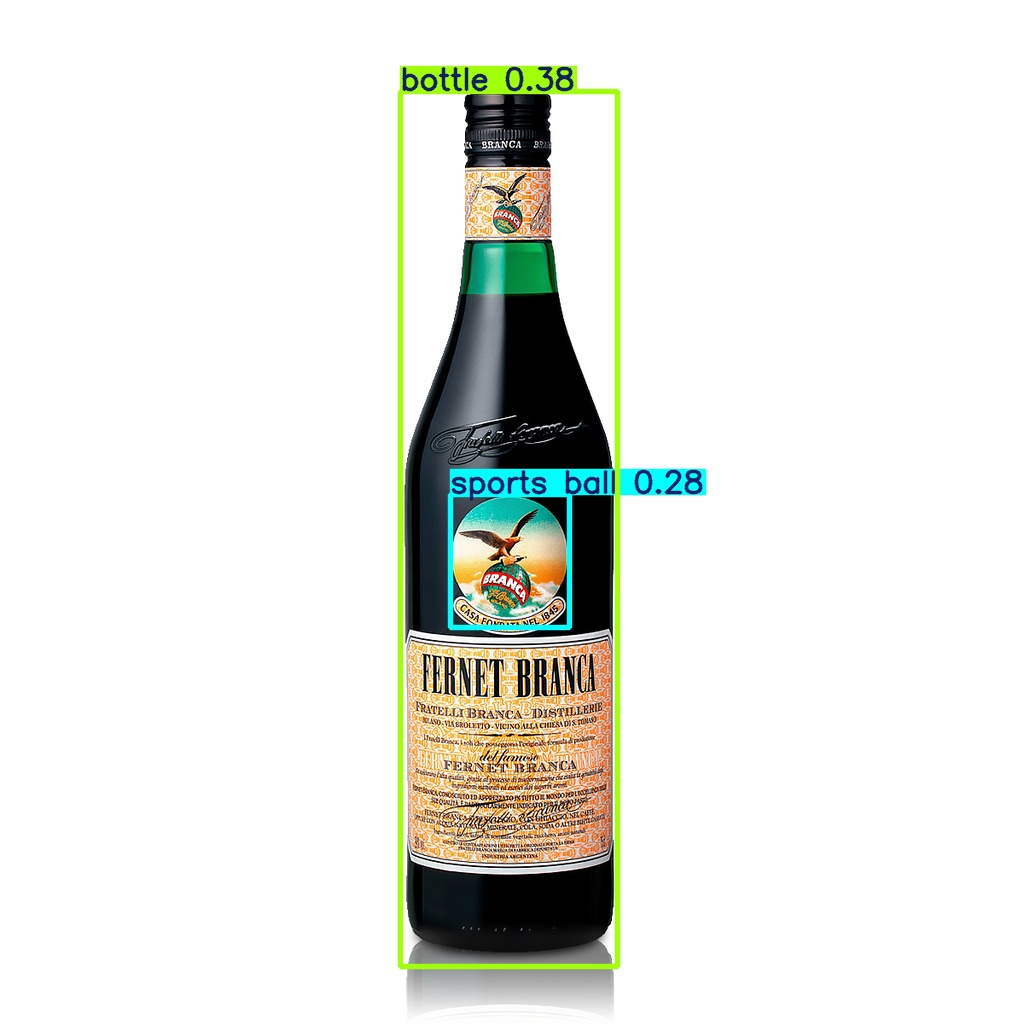

In [ ]:
IPyImage(filename=f'{HOME}/runs/detect/predict2/fernet.jpg', width=600)

## Fine-tuning de una YOLO11 nano sobre el dataset propio

Importamos ahora el dataset generado en Roboflow con las imágenes de fernet y con la única clase a detectar 'fernet'

In [ ]:
from google.colab import userdata

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=userdata.get('Robo_key'))
project = rf.workspace("proyecto-aprendizaje-automatico-ii").project("deteccion-de-fernet-a7hq8")
version = project.version(3)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Deteccion-de-fernet-3 in yolov11:: 100%|██████████| 118/118 [00:00<00:00, 5334.19it/s]


## Re-entrenamiento

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11n.pt data={dataset.location}/data.yaml epochs=100 imgsz=640 plots=True

/content
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Deteccion-de-fernet-3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0

Resultados del entrenamiento (con gráficas de desempeño) en `{HOME}/runs/detect/train/`.

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml			 labels.jpg	     train_batch1.jpg
BoxF1_curve.png			 results.csv	     train_batch2.jpg
BoxP_curve.png			 results.png	     val_batch0_labels.jpg
BoxPR_curve.png			 train_batch0.jpg    val_batch0_pred.jpg
BoxR_curve.png			 train_batch180.jpg  weights
confusion_matrix_normalized.png  train_batch181.jpg
confusion_matrix.png		 train_batch182.jpg


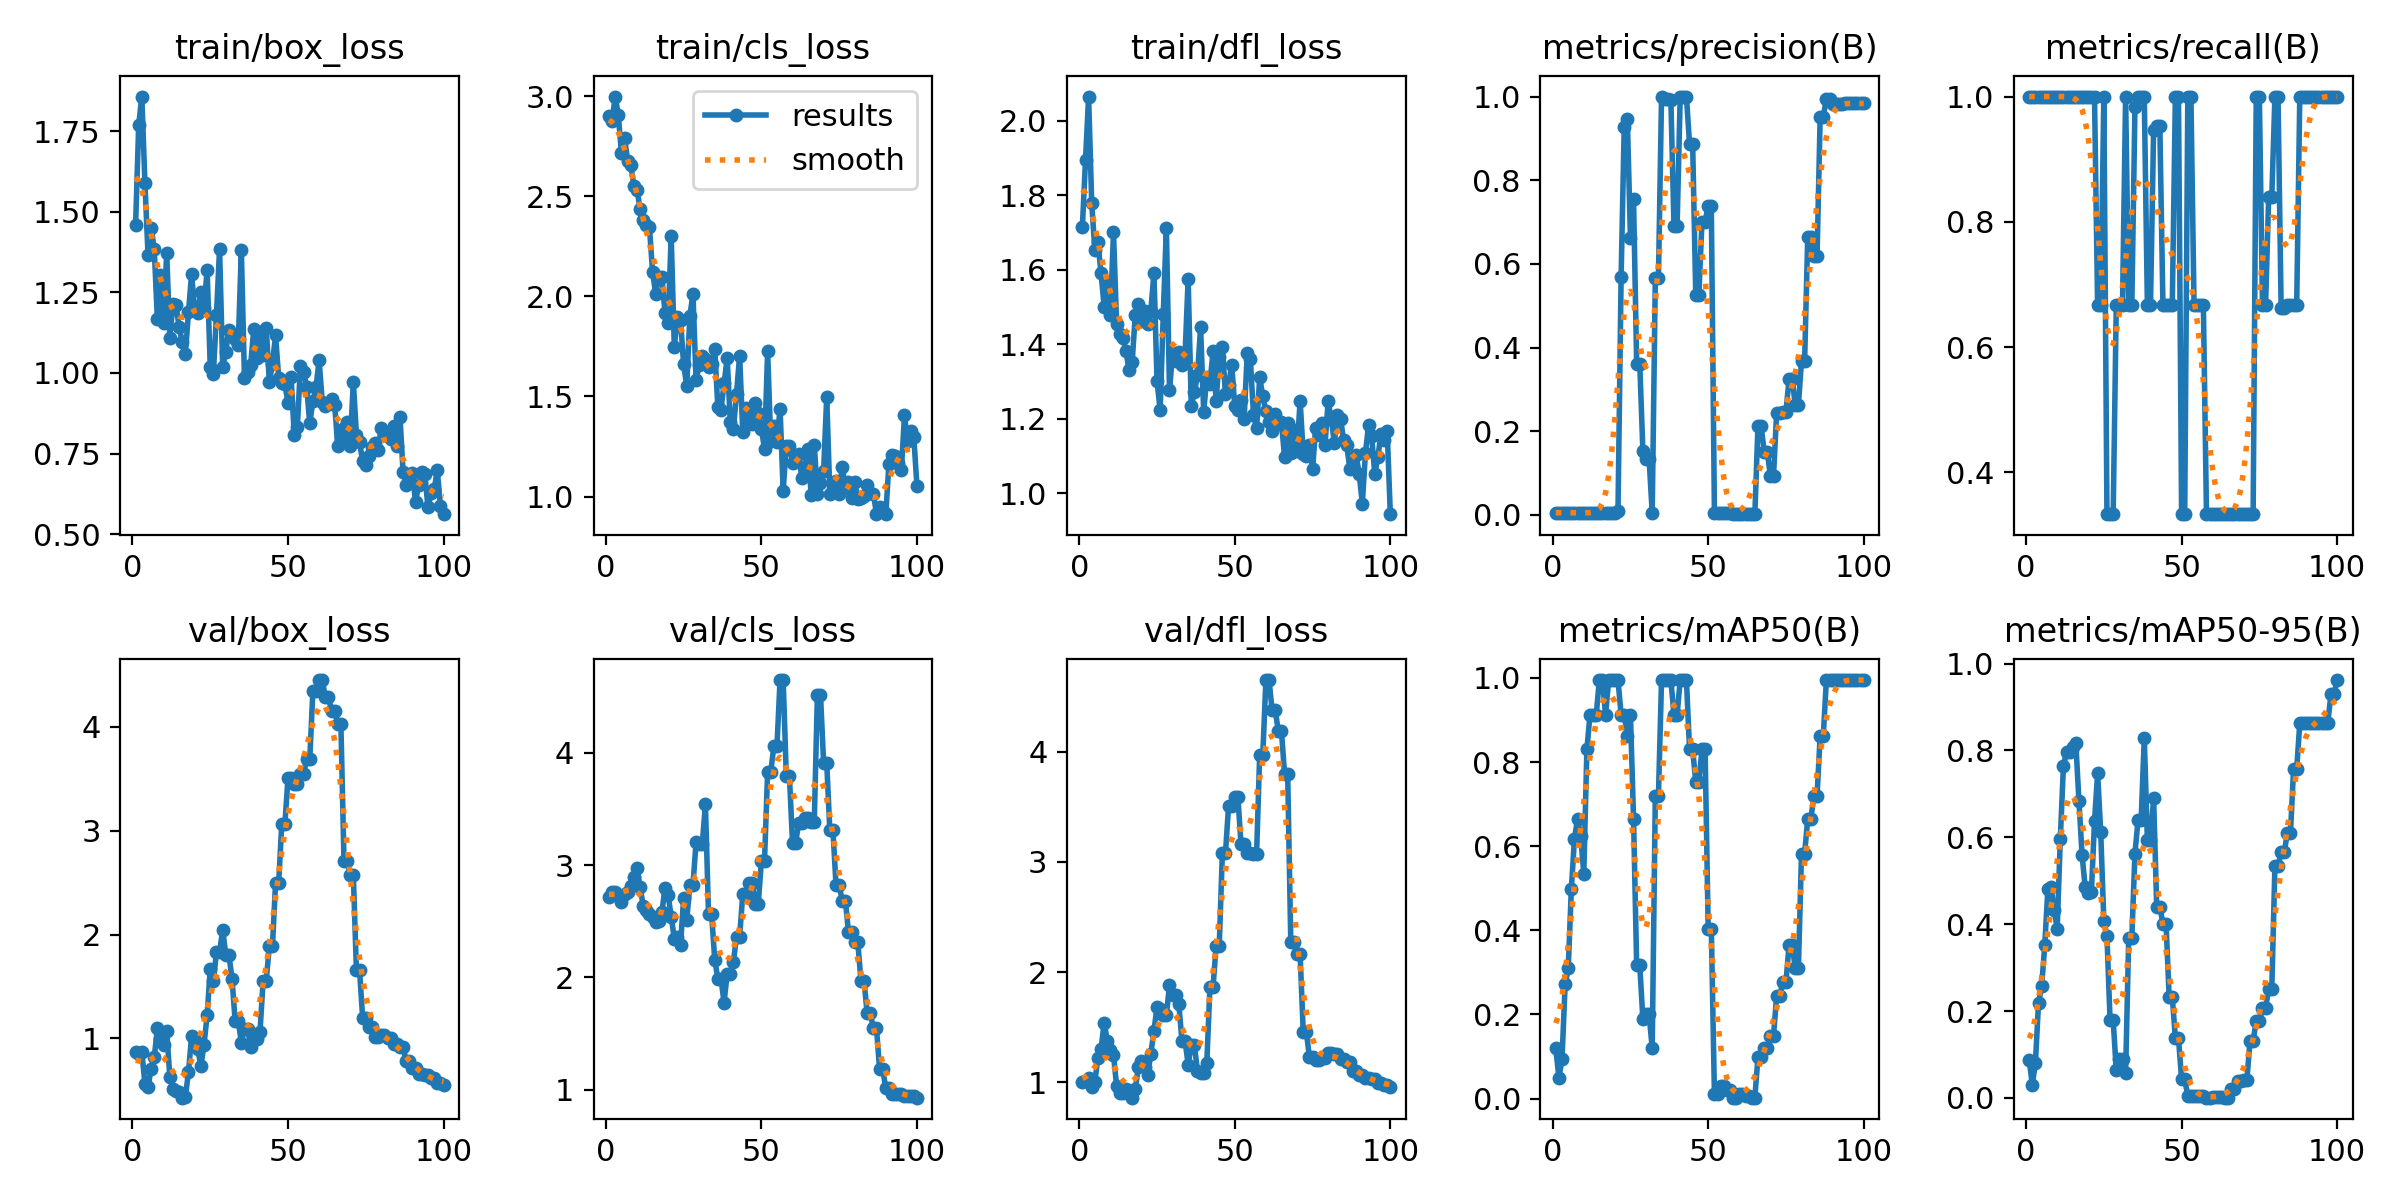

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

## Observaciones del entrenamiento
1. Pérdidas de entrenamiento (train/*_loss)

Se observa una tendencia claramente descendente en box_loss, cls_loss y dfl_loss.

Esto indica que el modelo está aprendiendo de manera consistente a lo largo de las épocas.

2. Pérdidas de validación (val/*_loss)

Las curvas muestran un pico intermedio y luego vuelven a descender.

Este comportamiento suele aparecer cuando:

* El dataset de validación es pequeño, por lo que las métricas son sensibles a pequeños cambios.

3. Métricas de precisión y recall

Los valores de precision y recall presentan oscilaciones fuertes, pasando repetidamente de 0 a 1.

Esto puede deberse a:

* Pocas imágenes en el conjunto de validación, especialmente para la nueva categoría.

* Alta similitud entre el set de entrenamiento y validación, lo que vuelve las métricas inestables.

Detección sobre las imágenes de validación.

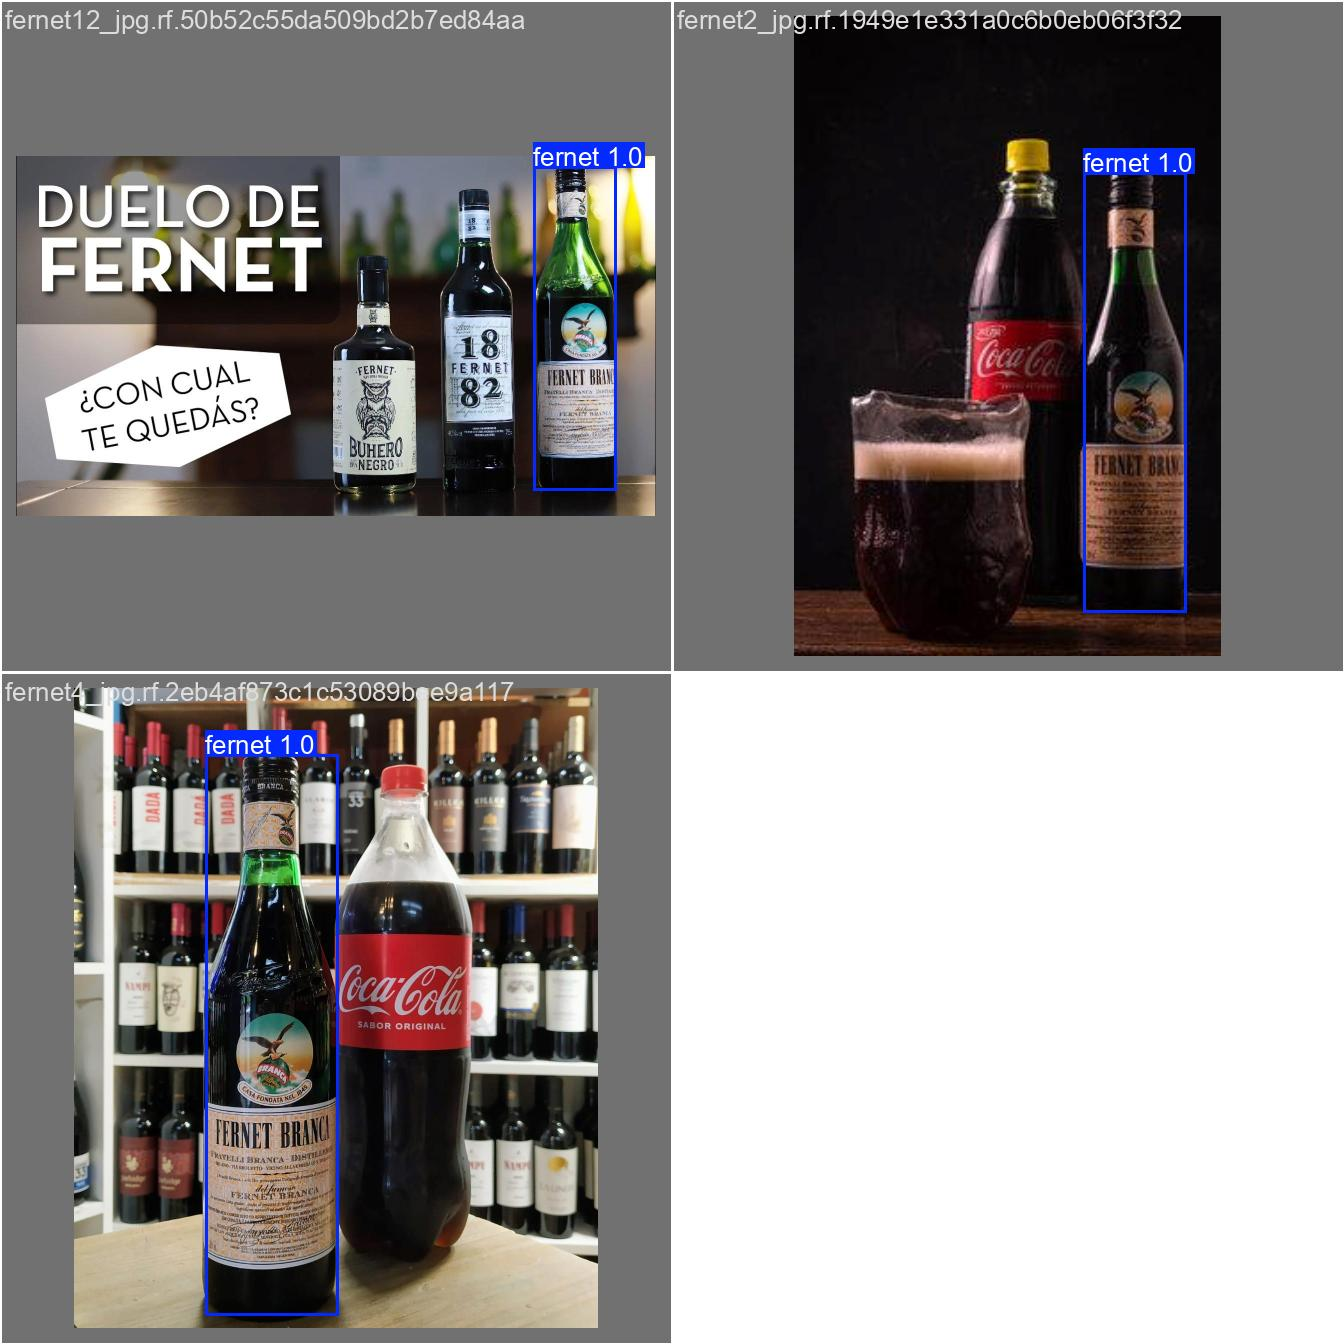

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Inferencia sobre imágenes de test

Corremos ahora la detección sobre las imágenes de test (no vistas en el entrenamiento)

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.2 source={dataset.location}/test/images save=True

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/2 /content/Deteccion-de-fernet-3/test/images/fernet20_jpg.rf.b5d81222299b74eb4fab661e979578b6.jpg: 512x640 1 fernet, 51.2ms
image 2/2 /content/Deteccion-de-fernet-3/test/images/fernet3_jpg.rf.61c02c6962fe140e4e16abba7d0a2ac3.jpg: 640x640 1 fernet, 8.6ms
Speed: 3.5ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict5
💡 Learn more at https://docs.ultralytics.com/modes/predict


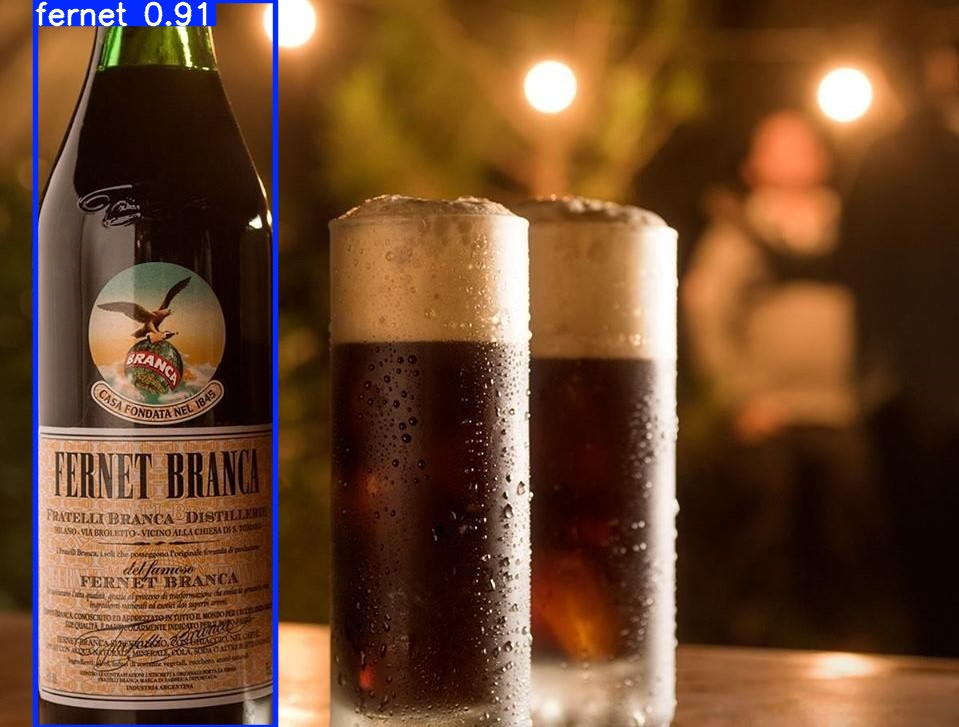

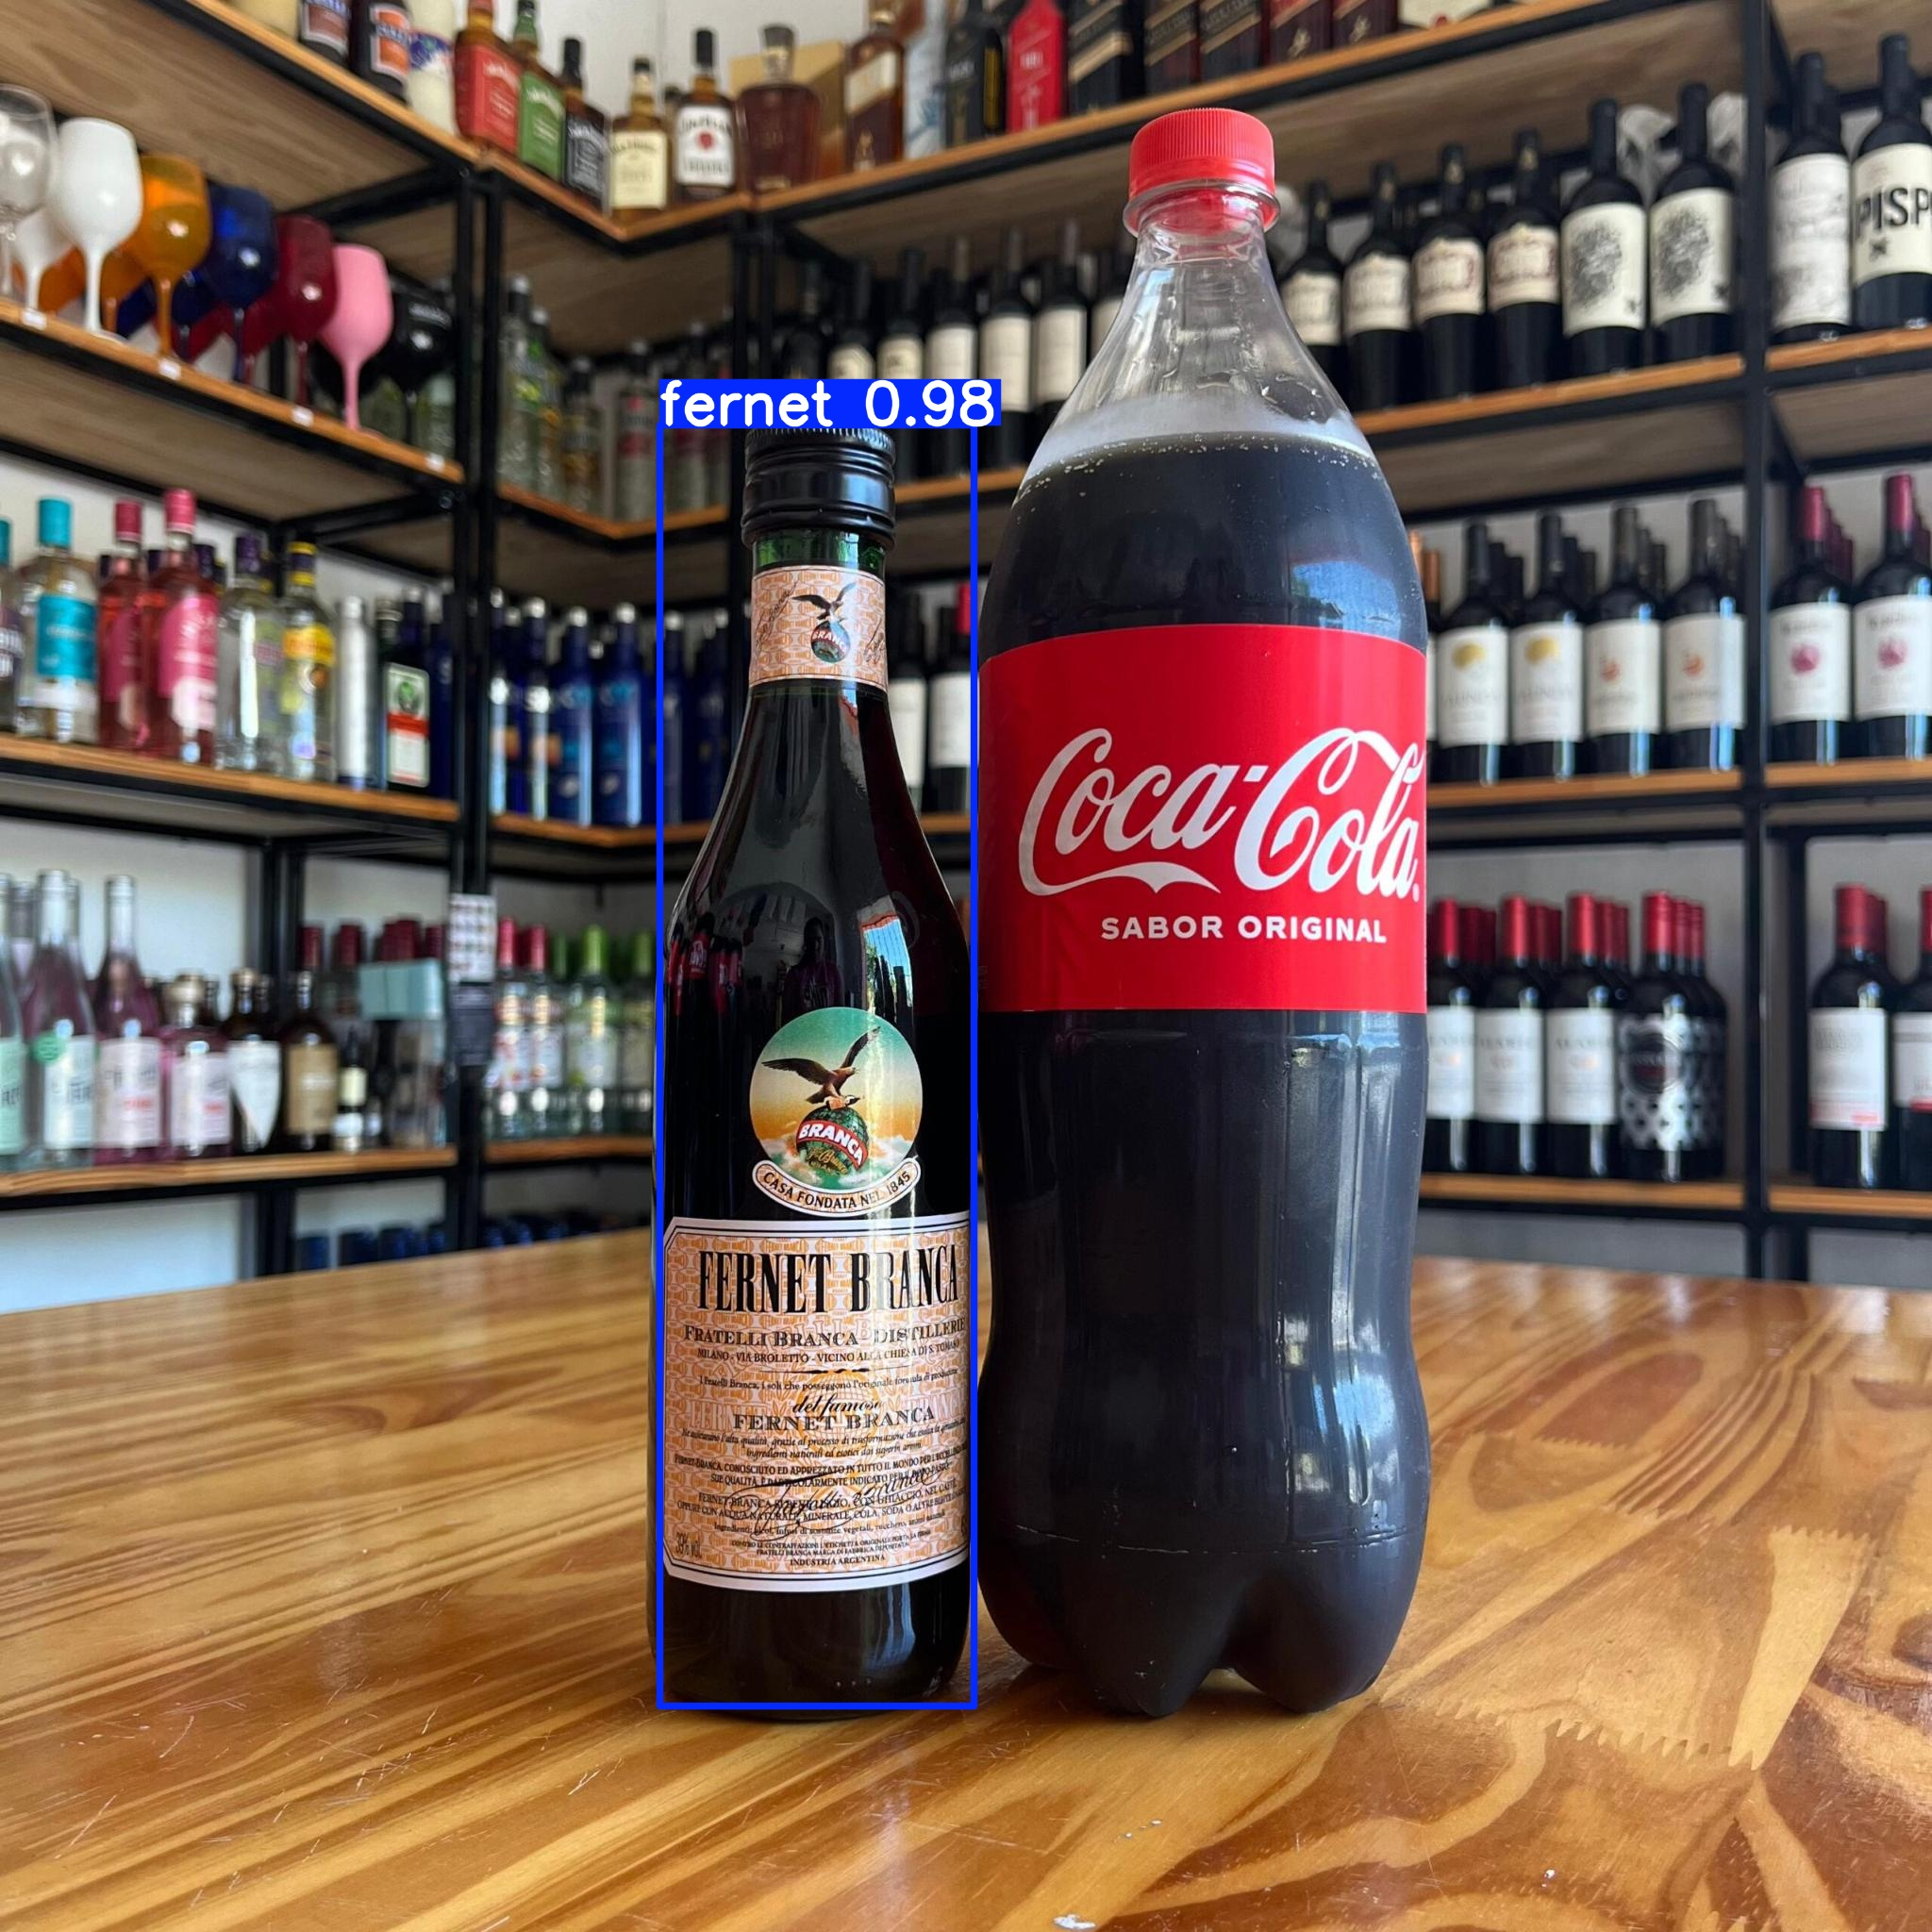

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict5/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Imagenes adicionales para prueba

Se descarga una imagen nueva y se sube al directorio raíz, para hacer inferencia y mostrar resultados.

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/1 /content/drive/MyDrive/fernet_test.jpg: 640x352 1 fernet, 70.4ms
Speed: 3.4ms preprocess, 70.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 352)
Results saved to /content/runs/detect/predict6
💡 Learn more at https://docs.ultralytics.com/modes/predict
Results saved to: /content/runs/detect/predict6/


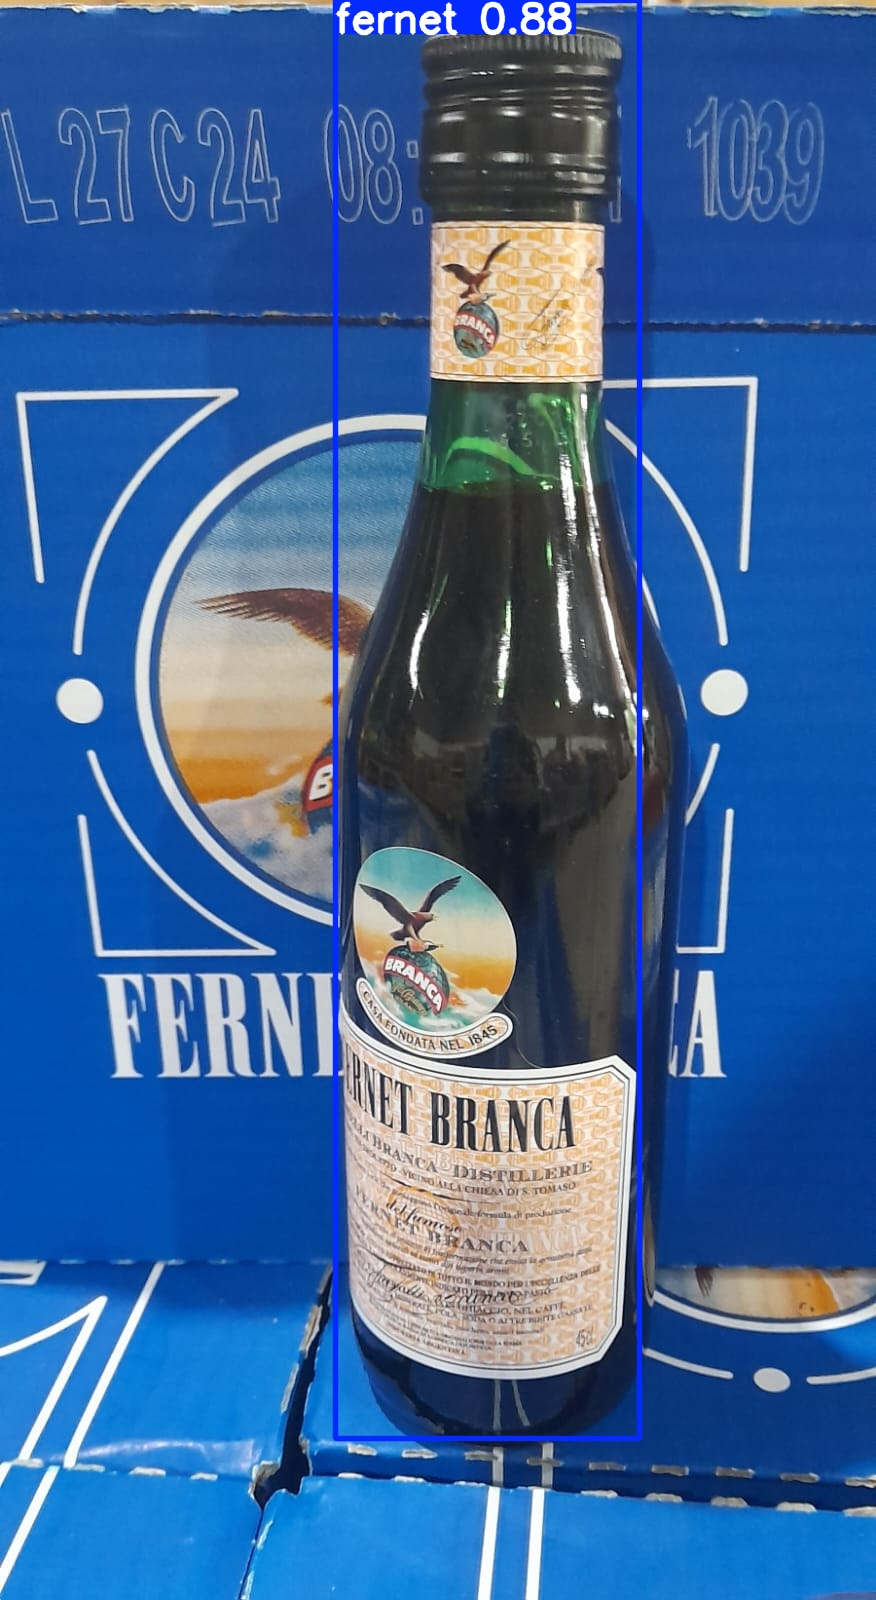

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source=/content/drive/MyDrive/fernet_test.jpg save=True

latest_predict_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
print(f"Results saved to: {latest_predict_folder}")
# Display the results
from IPython.display import Image as IPyImage, display
for img in glob.glob(f'{latest_predict_folder}/*.jpg'):
    display(IPyImage(filename=img, width=600))
    print("\n")

Probamos la misma imagen pero rotada, y subimos el umbral de confianza para eliminar ruido.

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/1 /content/drive/MyDrive/fernet_test2.jpg: 352x640 1 fernet, 49.2ms
Speed: 3.0ms preprocess, 49.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to /content/runs/detect/predict9
💡 Learn more at https://docs.ultralytics.com/modes/predict
Results saved to: /content/runs/detect/predict9/


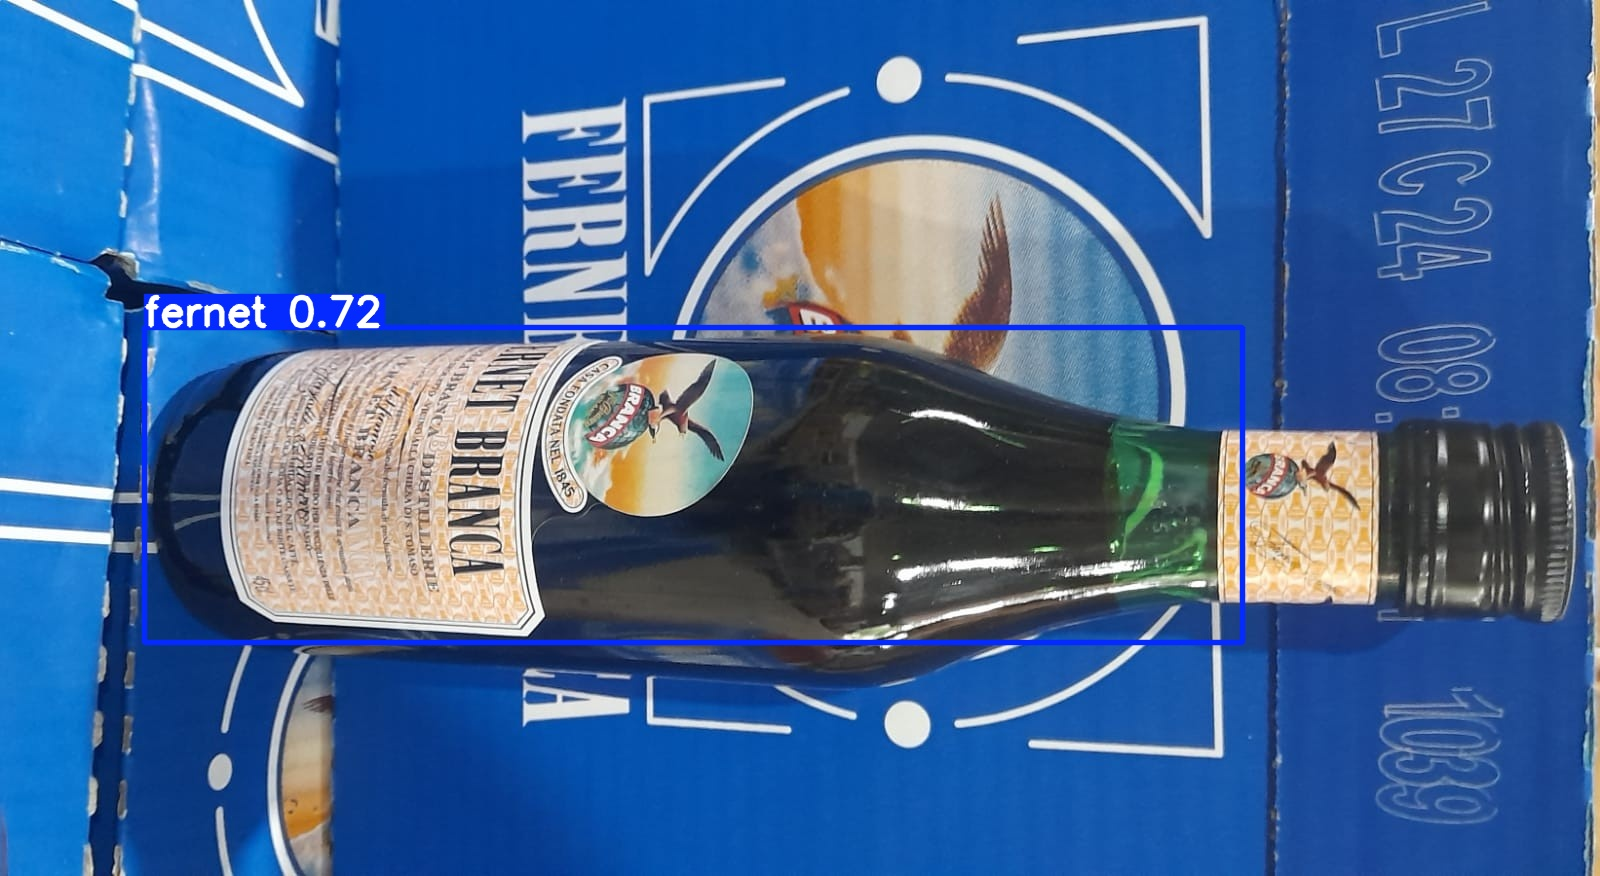

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.7 source=/content/drive/MyDrive/fernet_test2.jpg save=True

latest_predict_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
print(f"Results saved to: {latest_predict_folder}")
# Display the results
from IPython.display import Image as IPyImage, display
for img in glob.glob(f'{latest_predict_folder}/*.jpg'):
    display(IPyImage(filename=img, width=600))
    print("\n")

Vemos que aunque cae levemente la misma, detecta la nueva categoria.

In [ ]:
# prompt: exportar el modelo generado en un formato preparado para luego hacer inferencia con código python local

import os

# Specify the path to the trained model weights
model_path = os.path.join(HOME, "runs/detect/train/weights/best.pt")

# Export the model to ONNX format (or other desired format)
!yolo export model={model_path} format=onnx
# Or for other formats like TorchScript:
#!yolo export model={model_path} format=torchscript

# Optionally, you can specify the output path for the exported model
# !yolo export model={model_path} format=onnx opset=12 imgsz=640 --dynamic

print(f"Exported model saved to: {os.path.dirname(model_path)}")

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 191ms
Prepared 6 packages in 1.44s
Installed 6 packages in 252ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime==1.24.0.dev20251031003
 + onnxslim==0.1.77

requirements: AutoUpdate success ✅ 2.4s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX:

### Carga del modelo

In [ ]:
from ultralytics import YOLO

# Load the pre-trained YOLOv11 model from Google Drive
modelo = YOLO('/content/drive/MyDrive/ISTEA/Aprendizaje Automatico II/Parcial 2/Imagenes/best.pt')


image 1/1 /content/drive/MyDrive/fernet_test.jpg: 640x352 1 fernet, 79.7ms
Speed: 4.8ms preprocess, 79.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 352)
Results saved to /content/runs/detect/predict7
Boxes: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.8787], device='cuda:0')
data: tensor([[3.3599e+02, 0.0000e+00, 6.3919e+02, 1.4388e+03, 8.7875e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1600, 876)
shape: torch.Size([1, 6])
xywh: tensor([[ 487.5894,  719.3914,  303.1999, 1438.7827]], device='cuda:0')
xywhn: tensor([[0.5566, 0.4496, 0.3461, 0.8992]], device='cuda:0')
xyxy: tensor([[ 335.9894,    0.0000,  639.1893, 1438.7827]], device='cuda:0')
xyxyn: tensor([[0.3835, 0.0000, 0.7297, 0.8992]], device='cuda:0')


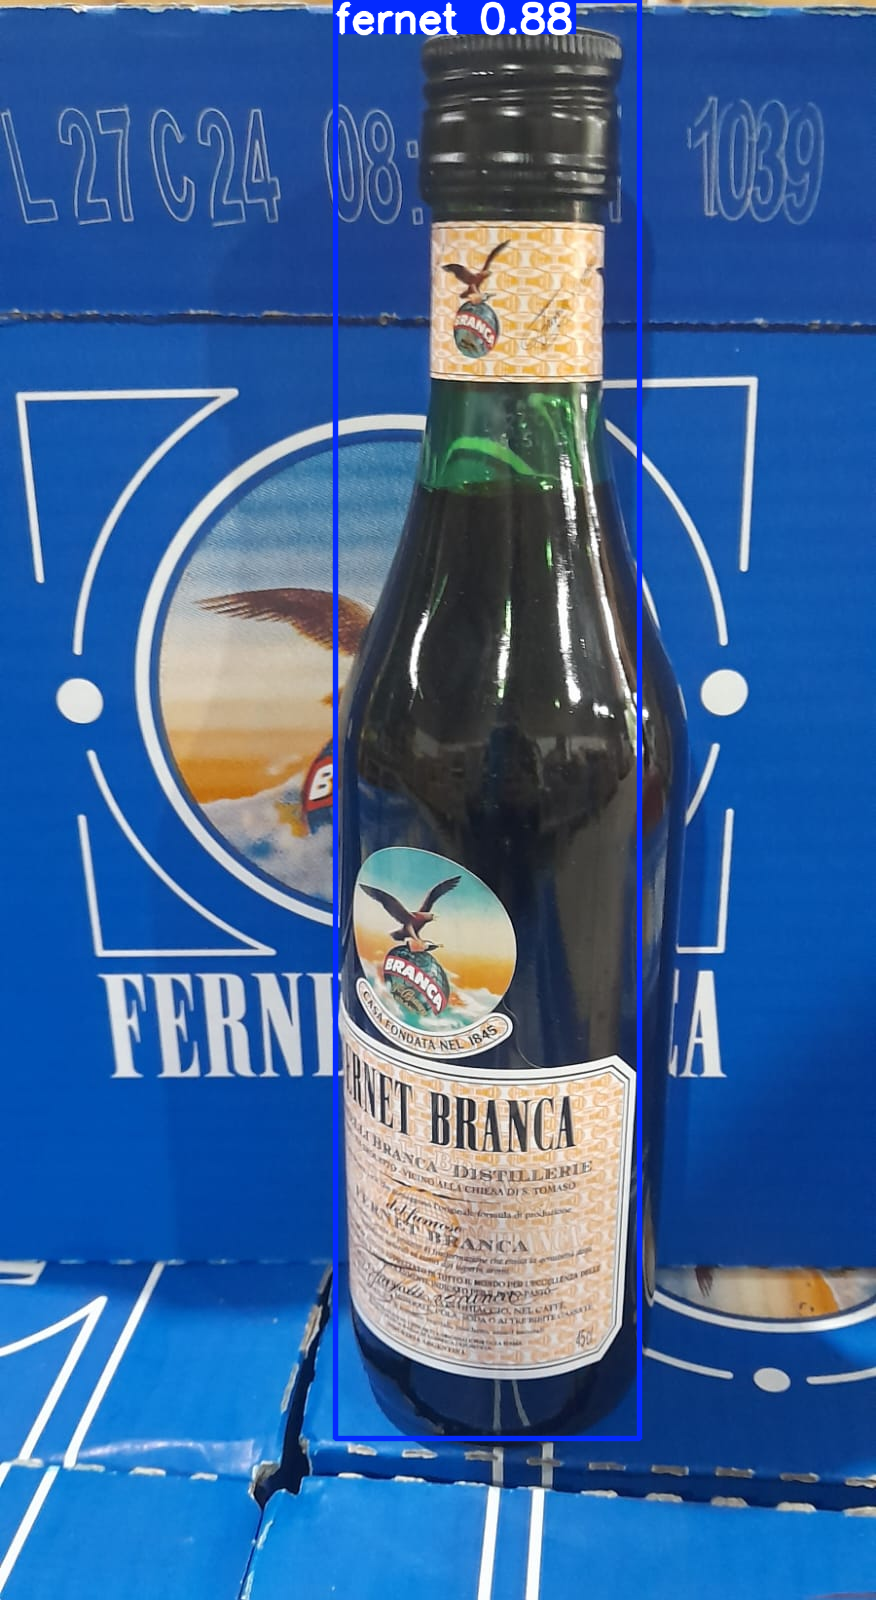

In [ ]:
# Assuming you have an image you want to test, for example 'test_image.jpg'
# You can use the predict method of the YOLO model object

results = modelo.predict(source='/content/drive/MyDrive/fernet_test.jpg', save=True, conf=0.25)

# The results object contains the detection results
# You can access information like bounding boxes, class labels, and confidence scores

# To display the results, you can iterate through them
for r in results:
    # r.boxes contains the bounding boxes
    # r.probs contains the classification probabilities (for classification tasks)
    # r.masks contains the segmentation masks (for segmentation tasks)
    # r.keypoints contains the keypoints (for pose estimation tasks)
    print(f"Boxes: {r.boxes}")
    # You can also visualize the results
    r.show() # This will display the image with detections

# The predicted image with bounding boxes is saved to a 'runs/detect/predict' directory by default.
# You can display the saved image as shown in previous cells.